####Bibliotecas

In [116]:
!pip install networkx

In [117]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import numpy as np


### Questão 1:

Implemente o Algoritmo A*, usando a Busca em Largura como modelo e usando uma fila de prioridade para a fronteira.

In [118]:
class MinHeap:
  def __init__(self):
      self.contents = []
      self.capacity = 0
      self.size = 0

  #remove o menor elemento do heap e reestabelece a ordem correta
  def remove_min(self):
      if self.size < 1:
          return None

      #guarda o menor elemento e coloca o ultimo elemento na raiz
      minimo = self.contents[0]
      self.contents[0] = self.contents[self.size-1]
      self.size -= 1

      #reestabelece a propriedade do min-heap
      self.__min_heapify(0)

      return minimo

  def adiciona(self, node):
      indice = self.size
      if self.capacity == self.size:
          self.contents.append(node)
          self.capacity += 1
      self.__insert(indice, node)
      self.size += 1


  #metodos privados
  def __pai(self, i):
      return (i - 1) // 2

  def __filho_esquerdo(self, i):
      return i * 2 + 1

  def __filho_direito(self, i):
      return i * 2 + 2

  def __swap(self, i, j):
      self.contents[i], self.contents[j] = self.contents[j], self.contents[i]

  def __min_heapify(self, i):
      l = self.__filho_esquerdo(i)
      r = self.__filho_direito(i)

      #encontra qual o menor dos tres nos: i, l ou r
      minimo = i

      if l < self.size and self.contents[i].f > self.contents[l].f:
          minimo = l

      if r < self.size and self.contents[minimo].f > self.contents[r].f:
          minimo = r

      #se i nao for o menor no, troca de lugar com o menor e continua recursivamente
      if minimo != i:
          self.__swap(i, minimo)
          self.__min_heapify(minimo)

  def __insert(self, i, node):
      self.contents[i] = node
      while i > 0 and self.contents[self.__pai(i)].f > self.contents[i].f:
          self.__swap(i, self.__pai(i))
          i = self.__pai(i)


#uma fila de prioridade que retorna os nos de valor minimo primeiro
class PriorityQueue:
  def __init__(self):
      self.heap = MinHeap()

  def remove_min(self):
      return self.heap.remove_min()

  def adiciona(self, prioridade, node):  #aceita a prioridade e o nó, separadamente
      self.heap.adiciona((prioridade, node))  #adiciona o par (prioridade, nó) à fronteira


#ordena uma lista de numeros usando um heap, para testar a implementção
def heap_sort(numeros):
  heap = MinHeap()

  class NoNumerico:
      def __init__(self, n):
          self.f = n

  for num in numeros:
      heap.adiciona(NoNumerico(num))

  resultado = []
  while heap.size > 0:
      n = heap.remove_min()
      if n is not None:
          resultado.append(n.f)

  return resultado


####resolvendo Q1

In [119]:
# Dicionário que representa o grafo de conexões entre as cidades
estados_romenia = {
  'Arad': [(75, 'Zerind'), (140, 'Sibiu'), (118, 'Timisoara')],
  'Bucharest': [(101, 'Fagaras'), (90, 'Pitesti'), (85, 'Giurgiu'), (211, 'Urziceni')],
  'Craiova': [(120, 'Pitesti'), (138, 'Rimnicu Vilcea'), (146, 'Dobreta')],
  'Dobreta': [(120, 'Mehadia'), (138, 'Craiova')],
  'Eforie': [(86, 'Hirsova')],
  'Fagaras': [(99, 'Sibiu'), (211, 'Bucharest')],
  'Giurgiu': [(90, 'Bucharest')],
  'Hirsova': [(86, 'Eforie'), (98, 'Urziceni')],
  'Iasi': [(92, 'Vaslui'), (87, 'Neamt')],
  'Lugoj': [(70, 'Timisoara'), (111, 'Mehadia')],
  'Mehadia': [(75, 'Lugoj'), (70, 'Dobreta')],
  'Neamt': [(87, 'Iasi')],
  'Oradea': [(71, 'Zerind'), (151, 'Sibiu')],
  'Pitesti': [(97, 'Rimnicu Vilcea'), (138, 'Craiova'), (101, 'Bucharest')],
  'Rimnicu Vilcea': [(146, 'Craiova'), (97, 'Pitesti'), (80, 'Sibiu')],
  'Sibiu': [(140, 'Arad'), (151, 'Oradea'), (99, 'Fagaras'), (80, 'Rimnicu Vilcea')],
  'Timisoara': [(118, 'Arad'), (111, 'Lugoj')],
  'Urziceni': [(85, 'Bucharest'), (98, 'Hirsova'), (142, 'Vaslui')],
  'Vaslui': [(142, 'Urziceni'), (92, 'Iasi')],
  'Zerind': [(71, 'Oradea'), (75, 'Arad')]
}

# Função heurística para estimar a distância restante de cada cidade até Bucharest
heuristica_romenia = {
  'Arad': 366,
  'Bucharest': 0,
  'Craiova': 160,
  'Dobreta': 242,
  'Eforie': 161,
  'Fagaras': 176,
  'Giurgiu': 77,
  'Hirsova': 151,
  'Iasi': 226,
  'Lugoj': 244,
  'Mehadia': 241,
  'Neamt': 234,
  'Oradea': 380,
  'Pitesti': 100,
  'Rimnicu Vilcea': 193,
  'Sibiu': 253,
  'Timisoara': 329,
  'Urziceni': 80,
  'Vaslui': 199,
  'Zerind': 374
}

In [120]:
class Problema:
    def __init__(self, grafo, estado_inicial, estado_final, heuristica):
        self.grafo = grafo
        self.estado_inicial = estado_inicial
        self.estado_final = estado_final
        self.heuristica = heuristica

    def acoes(self, estado):
        return self.grafo.get(estado, [])

    def resultado(self, estado, acao):
        return acao[1]

    def custo(self, estado, acao):
        return acao[0]

    def objetivo(self, estado):
        return estado == self.estado_final

    def heuristica_estado(self, estado):
        return self.heuristica[estado]

def a_star_search(problema):
    fila_prioridade = []
    heapq.heappush(fila_prioridade, (0, problema.estado_inicial))
    visitados = set()
    pais = {}
    custos = {problema.estado_inicial: 0}

    while fila_prioridade:
        custo_atual, estado_atual = heapq.heappop(fila_prioridade)

        if problema.objetivo(estado_atual):
            caminho = []
            while estado_atual in pais:
                caminho.insert(0, estado_atual)
                estado_atual = pais[estado_atual]
            return caminho

        visitados.add(estado_atual)

        for acao in problema.acoes(estado_atual):
            proximo_estado = problema.resultado(estado_atual, acao)
            novo_custo = custos[estado_atual] + problema.custo(estado_atual, acao)

            if proximo_estado not in custos or novo_custo < custos[proximo_estado]:
                custos[proximo_estado] = novo_custo
                prioridade = novo_custo + problema.heuristica_estado(proximo_estado)
                heapq.heappush(fila_prioridade, (prioridade, proximo_estado))
                pais[proximo_estado] = estado_atual

    return None

In [121]:
# Criando o problema da busca na Romênia
problema_romenia = Problema(
  estados_romenia,
  'Arad',
  'Bucharest',
  heuristica_romenia
)

In [122]:
#chamando a função de busca do algortimo A*
caminho_romenia = a_star_search(problema_romenia)
print(caminho_romenia)


['Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']


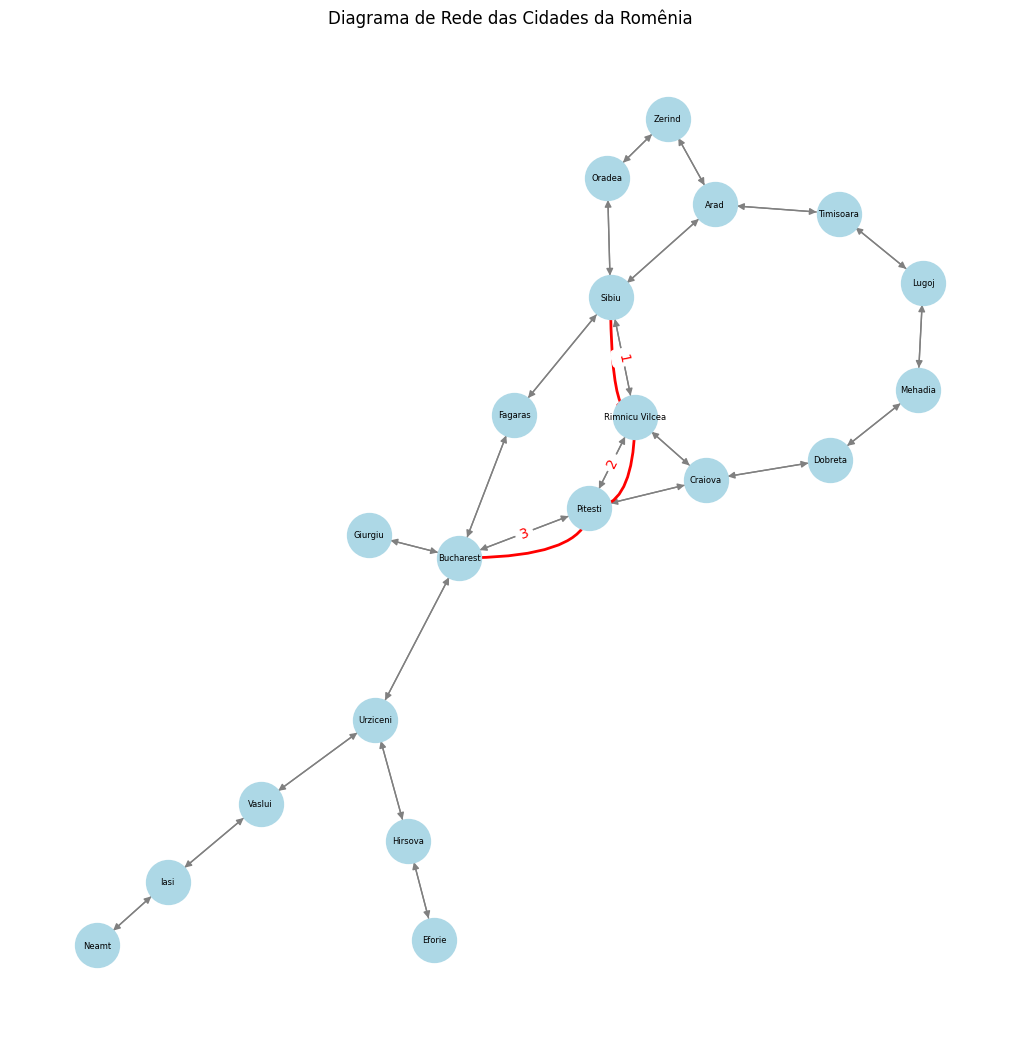

In [123]:
def plotar_diagrama_rede(estados_romenia, caminho):
    #cria um grafo direcionado
    G = nx.DiGraph()

    #adicionar os nós
    for cidade in estados_romenia.keys():
        G.add_node(cidade)

    #adiciona as arestas com seus custos respectivos
    for cidade, conexoes in estados_romenia.items():
        for distancia, cidade_destino in conexoes:
            G.add_edge(cidade, cidade_destino, distance=distancia)

    #layout do grafo
    layout = nx.spring_layout(G)

    plt.figure(figsize=(10, 10))
    nx.draw(G, layout, with_labels=True, node_size=1000, node_color='lightblue', edge_color='gray', font_size=6, arrowsize=10)

    #para destacar o caminho (linha vermelha)
    caminho_edges = [(caminho[i], caminho[i+1]) for i in range(len(caminho)-1)]
    nx.draw_networkx_edges(G, layout, edgelist=caminho_edges, edge_color='red', width=2,
                           connectionstyle='angle3')  # Ajuste a direção das setas com 'arc3,rad=0.1'

    #adiociona rótulos às arestas para indicar a direção do caminho
    edge_labels = {(caminho[i], caminho[i+1]): i+1 for i in range(len(caminho)-1)}
    nx.draw_networkx_edge_labels(G, layout, edge_labels=edge_labels, font_color='red', font_size=10)

    plt.title('Diagrama de Rede das Cidades da Romênia')
    plt.show()

#chama a função para plotar o diagrama de rede com o caminho destacado
plotar_diagrama_rede(estados_romenia, caminho_romenia)


### Questão 2

Usando a implementação do A* desenvolvida para a questão anterior, resolva o problema de busca de rotas na Romênia (de Arad a Bucareste). Mostre o passo a passo da solução.

In [124]:
import heapq

def a_star_search_verbose(problema):
    fila_prioridade = []
    heapq.heappush(fila_prioridade, (0, problema.estado_inicial))
    visitados = set()
    pais = {}
    custos = {problema.estado_inicial: 0}

    passo = 0  # Variável para acompanhar o número de passos

    while fila_prioridade:
        custo_atual, estado_atual = heapq.heappop(fila_prioridade)
        print(f"Passo {passo}: Explorando estado {estado_atual} com custo {custo_atual}")

        if problema.objetivo(estado_atual):
            caminho = []
            while estado_atual in pais:
                caminho.insert(0, estado_atual)
                estado_atual = pais[estado_atual]
            print("Solução encontrada!")
            return caminho

        visitados.add(estado_atual)

        for acao in problema.acoes(estado_atual):
            proximo_estado = problema.resultado(estado_atual, acao)
            novo_custo = custos[estado_atual] + problema.custo(estado_atual, acao)

            if proximo_estado not in custos or novo_custo < custos[proximo_estado]:
                custos[proximo_estado] = novo_custo
                prioridade = novo_custo + problema.heuristica_estado(proximo_estado)
                heapq.heappush(fila_prioridade, (prioridade, proximo_estado))
                pais[proximo_estado] = estado_atual

        passo += 1

    print("Não foi encontrada uma solução.")
    return None

In [125]:
# Criando o problema da busca na Romênia
problema_romenia2 = Problema(
  estados_romenia,
  'Arad',
  'Bucharest',
  heuristica_romenia
)
#chamando a função de busca do algortimo A*
caminho_romenia2 = a_star_search_verbose(problema_romenia2)
print(caminho_romenia2)


Passo 0: Explorando estado Arad com custo 0
Passo 1: Explorando estado Sibiu com custo 393
Passo 2: Explorando estado Rimnicu Vilcea com custo 413
Passo 3: Explorando estado Fagaras com custo 415
Passo 4: Explorando estado Pitesti com custo 417
Passo 5: Explorando estado Bucharest com custo 418
Solução encontrada!
['Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']


### Questão 3

A função heurística mostrada no livro (e nos vídeos) não pode ser utilizada para buscar a rota até outras cidades de destino na Romênia (tem que ser Bucareste), mas pode ser usada na busca de rotas mudando a cidade de origem (ao invés de Arad). Proponha e simule a busca de rotas de pelo menos duas outras cidades até Bucareste. Mostre o passo a passo do algoritmo buscando a solução.


In [126]:
# Criando o problema da busca na Romênia
problema_romenia3 = Problema(
  estados_romenia,
  'Timisoara',
  'Bucharest',
  heuristica_romenia
)
#chamando a função de busca do algortimo A*
caminho_romenia3 = a_star_search_verbose(problema_romenia3)
print(caminho_romenia3)


Passo 0: Explorando estado Timisoara com custo 0
Passo 1: Explorando estado Lugoj com custo 355
Passo 2: Explorando estado Mehadia com custo 463
Passo 3: Explorando estado Arad com custo 484
Passo 4: Explorando estado Sibiu com custo 511
Passo 5: Explorando estado Rimnicu Vilcea com custo 531
Passo 6: Explorando estado Fagaras com custo 533
Passo 7: Explorando estado Dobreta com custo 534
Passo 8: Explorando estado Pitesti com custo 535
Passo 9: Explorando estado Bucharest com custo 536
Solução encontrada!
['Arad', 'Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']


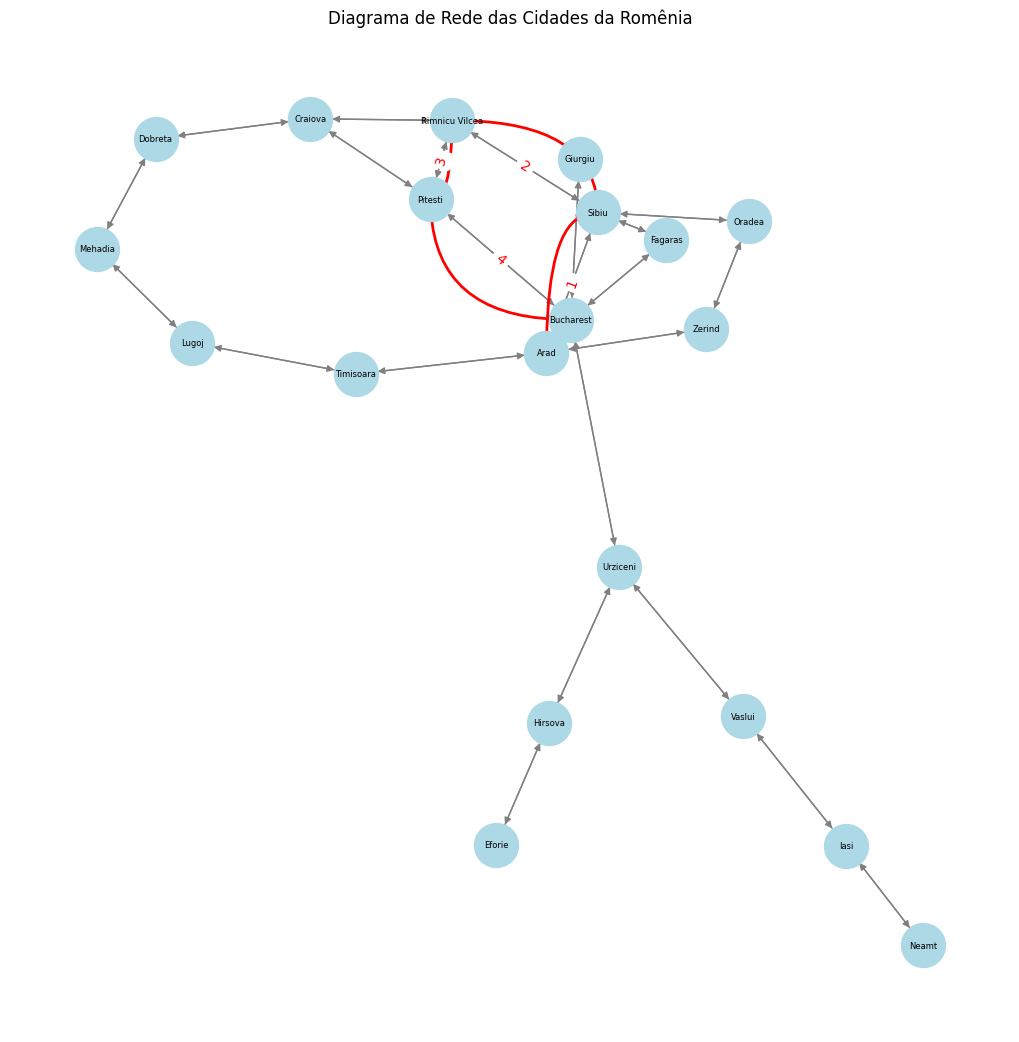

In [127]:
#chama a função para plotar o diagrama de rede com o caminho a partir de Timisoara
plotar_diagrama_rede(estados_romenia, caminho_romenia3)

In [128]:
# Criando o problema da busca na Romênia
problema_romenia3_1 = Problema(
  estados_romenia,
  'Neamt',
  'Bucharest',
  heuristica_romenia
)
#chamando a função de busca do algortimo A*
caminho_romenia3_1 = a_star_search_verbose(problema_romenia3_1)
print(caminho_romenia3_1)


Passo 0: Explorando estado Neamt com custo 0
Passo 1: Explorando estado Iasi com custo 313
Passo 2: Explorando estado Vaslui com custo 378
Passo 3: Explorando estado Urziceni com custo 401
Passo 4: Explorando estado Bucharest com custo 406
Solução encontrada!
['Iasi', 'Vaslui', 'Urziceni', 'Bucharest']


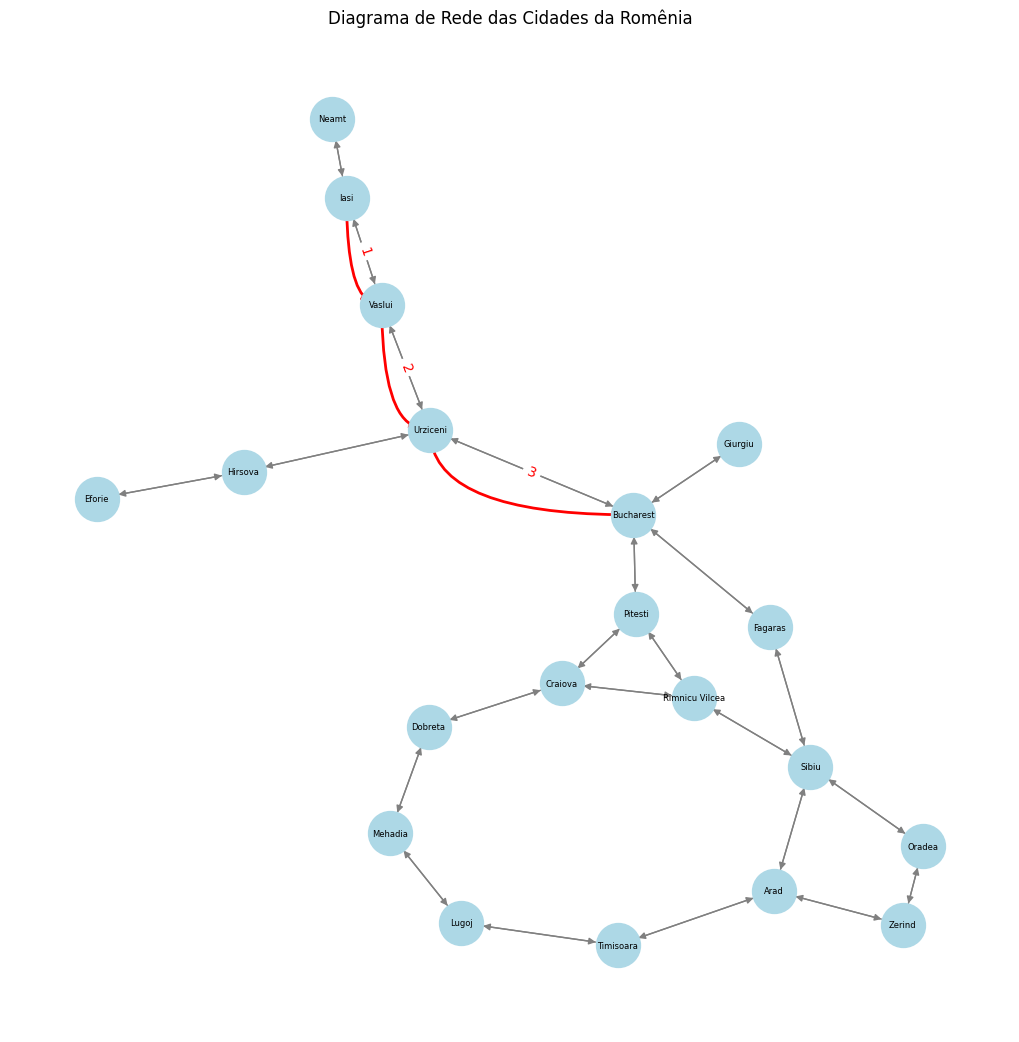

In [129]:
#chama a função para plotar o diagrama de rede com o caminho a partir de Neamt
plotar_diagrama_rede(estados_romenia, caminho_romenia3_1)

### Questão 4

Use algum aplicativo de mapas (ou outra fonte de informações geográficas) para obter a distância em linha reta, e crie uma função heurística para resolver problemas de rotas nas cidades da Romênia tendo outra cidade de destino diferente de Bucareste. Resolva algum problema de rota usando a função heurística criada, e mostre o passo a passo da busca.

cidades escolhidas: Arad até Vaslui (496,54km)

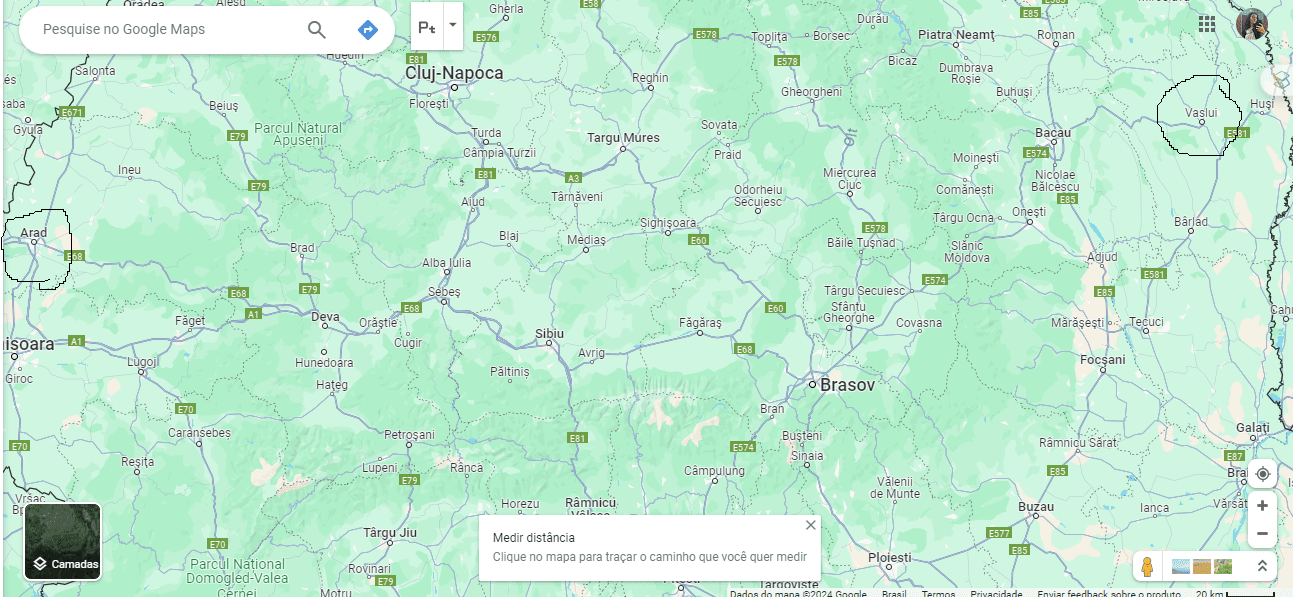

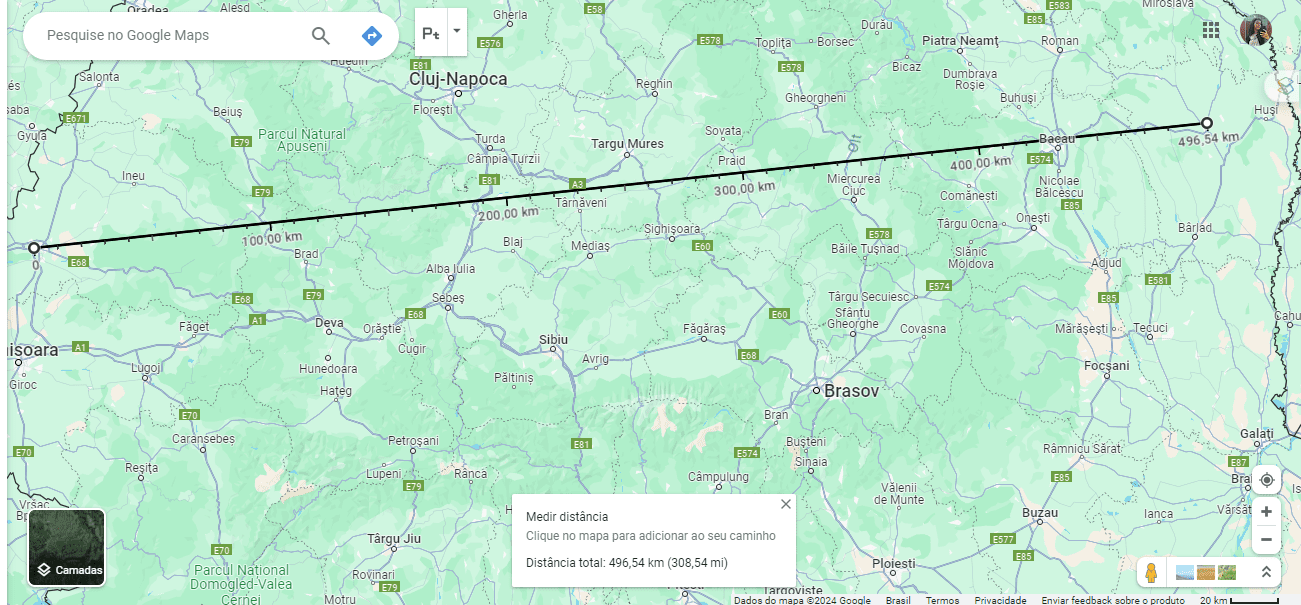

Para estimar a distância em linha reta entre duas cidades na Romênia, decidimos criar uma função heurística que usa a distância euclidiana entre as coordenadas das duas cidades.

As coordenadas das cidades usaram as informações reais de latitude e longitude para uma estimativa mais precisa. As informações foram retiradas de: https://simplemaps.com/data/ro-cities

In [130]:
coordenadas_romenia = {
    'Arad': (46.18634390358293, 21.30978719626534),
    'Bucharest': (44.429600348503996, 26.10141285396976),
    'Craiova': (44.329916018819404, 23.79756679574555),
    'Dobreta': (44.637409877325325, 22.66033177365745),
    'Eforie': (44.02598382599629, 28.647126323771303),
    'Fagaras': (45.84226111333714, 24.97096892528106),
    'Giurgiu': (43.90419971073856, 25.97298859283599),
    'Hirsova': (44.689799064051904, 27.94638675309768),
    'Iasi': (47.15765477085728, 27.602248261021625),
    'Lugoj': (45.691151326008, 21.904678345412233),
    'Mehadia': (44.90400047816181, 22.36689804581513),
    'Neamt': (46.93380739035945, 26.367732688279116),
    'Oradea': (47.05764026543065, 21.919763126890043),
    'Pitesti': (44.85633506165772, 24.868181346266216),
    'Rimnicu Vilcea': (45.10007392366445, 24.371109053966947),
    'Sibiu': (45.803464236684775, 24.146189669718453),
    'Timisoara': (45.74861161920077, 21.218821396648007),
    'Urziceni': (44.71674416342511, 26.64094354983247),
    'Vaslui': (46.640797246535094, 27.727775623067586),
    'Zerind': (46.62265349842936, 21.517067938754042)
}

In [131]:
def a_star_search_verbose(problema):
    fila_prioridade = []
    heapq.heappush(fila_prioridade, (0, problema.estado_inicial))
    visitados = set()
    pais = {}
    custos = {problema.estado_inicial: 0}

    passo = 0

    while fila_prioridade:
        custo_atual, estado_atual = heapq.heappop(fila_prioridade)
        print(f"Passo {passo}: Explorando estado {estado_atual} com custo {custo_atual}")

        if problema.objetivo(estado_atual):
            caminho = []
            while estado_atual in pais:
                caminho.insert(0, estado_atual)
                estado_atual = pais[estado_atual]
            print("Solução encontrada!")
            return caminho

        visitados.add(estado_atual)

        for acao in problema.acoes(estado_atual):
            proximo_estado = problema.resultado(estado_atual, acao)
            novo_custo = custos[estado_atual] + problema.custo(estado_atual, acao)

            if proximo_estado not in custos or novo_custo < custos[proximo_estado]:
                custos[proximo_estado] = novo_custo
                prioridade = novo_custo #removemos a heuristica por conta de um conflito
                heapq.heappush(fila_prioridade, (prioridade, proximo_estado))
                pais[proximo_estado] = estado_atual

        passo += 1

    print("Não foi encontrada uma solução.")
    return None

In [132]:
def distancia_euclidiana(coord1, coord2):
    #calcula a distância euclidiana (em linha reta) entre as duas coordenadas
    x1, y1 = coord1
    x2, y2 = coord2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

#função heurística de Arad até Vaslui em linha reta
def heuristica_arad_vaslui(estado):

    coordenadas_arad = coordenadas_romenia['Arad']
    coordenadas_vaslui = coordenadas_romenia['Vaslui']

    #calcula a distância euclidiana (em linha reta) entre Arad e Vaslui
    distancia = distancia_euclidiana(coordenadas_arad, coordenadas_vaslui)

    return distancia

#rota do novo problema
problema_romenia_arad_vaslui = Problema(
    estados_romenia,
    'Arad',
    'Vaslui',
    heuristica_arad_vaslui
)

#resolvendo o problema com busca A* a partir da nova heuristica
caminho_romenia_arad_vaslui = a_star_search_verbose(problema_romenia_arad_vaslui)
print("Caminho encontrado:", caminho_romenia_arad_vaslui)


Passo 0: Explorando estado Arad com custo 0
Passo 1: Explorando estado Zerind com custo 75
Passo 2: Explorando estado Timisoara com custo 118
Passo 3: Explorando estado Sibiu com custo 140
Passo 4: Explorando estado Oradea com custo 146
Passo 5: Explorando estado Rimnicu Vilcea com custo 220
Passo 6: Explorando estado Lugoj com custo 229
Passo 7: Explorando estado Fagaras com custo 239
Passo 8: Explorando estado Pitesti com custo 317
Passo 9: Explorando estado Mehadia com custo 340
Passo 10: Explorando estado Craiova com custo 366
Passo 11: Explorando estado Dobreta com custo 410
Passo 12: Explorando estado Bucharest com custo 418
Passo 13: Explorando estado Bucharest com custo 450
Passo 14: Explorando estado Giurgiu com custo 503
Passo 15: Explorando estado Urziceni com custo 629
Passo 16: Explorando estado Hirsova com custo 727
Passo 17: Explorando estado Vaslui com custo 771
Solução encontrada!
Caminho encontrado: ['Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest', 'Urziceni', 'Vasl

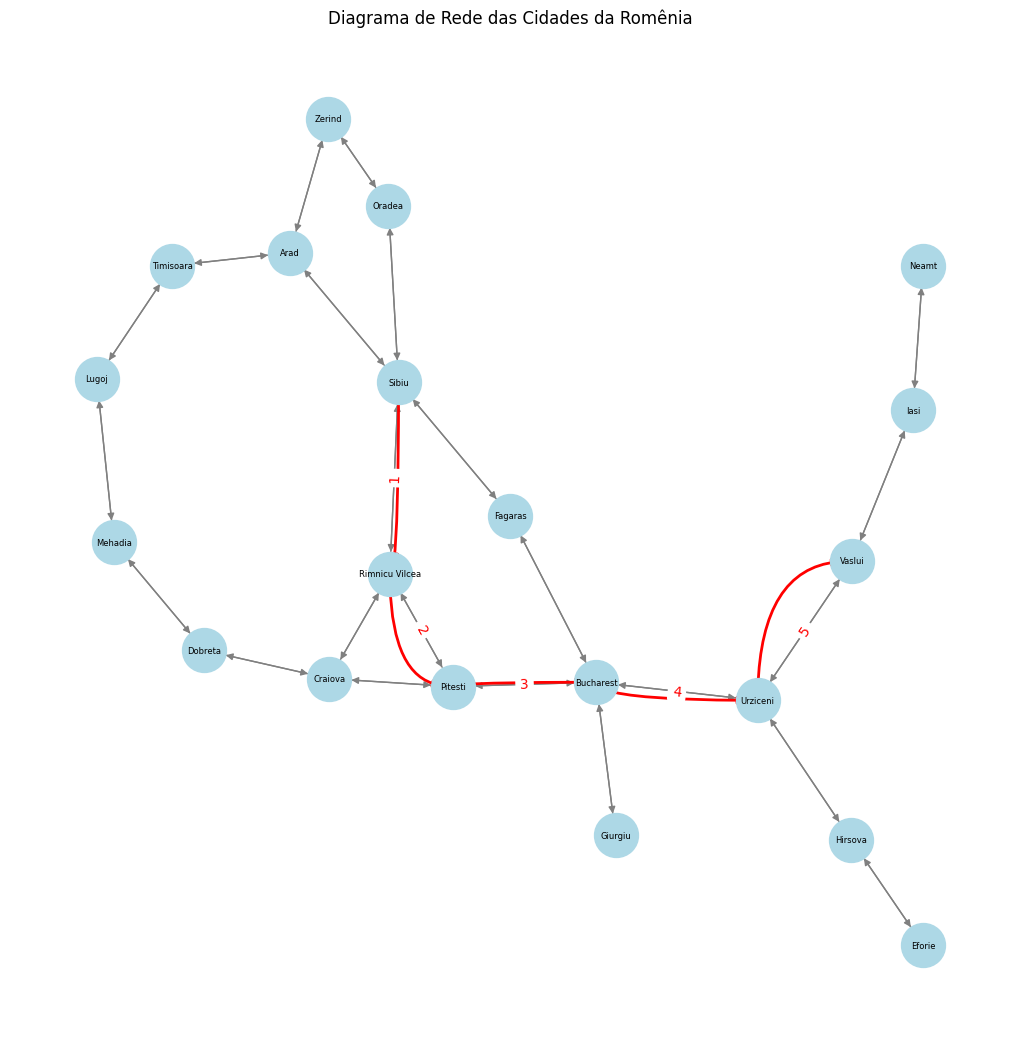

In [133]:
plotar_diagrama_rede(estados_romenia, caminho_romenia_arad_vaslui)


### Questão 5

Resolva outro problema (formulado como um problema de busca) usando o algoritmo A*. Escolha um problema em que o custo das ações não seja unitário. Pesquise sobre alguma função heurística para o problema, ou crie uma heurística admissível para ele. Mostre o passo a passo da busca pela solução.

Como podemos escolher, vamos considerar um problema de navegação de um robô em um ambiente com obstáculos.

O robô em questão precisa se locomover do ponto inicial até o ponto final, evitando colisões com obstáculos e minimizando a distância percorrida (custo não-unitário).


---

Definição do Problema:

*Estado Inicial (S): Posição inicial do robô.*

*Estado Final (G): Posição final desejada.*

*Ações Possíveis: cima, baixo, esquerda, direita e diagonais.*

*Custo das Ações: O custo de cada ação é a distância percorrida pelo robô para alcançar o próximo estado. Vamos considerar a distância Euclidiana como métrica para calcular o custo.*

*Por conta do custo, usaremos a heurística da distancia Euclidiana.*

In [140]:
def distancia_euclidiana(origem, destino):
    x1, y1 = origem
    x2, y2 = destino
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

class problema_navegacao:
    def __init__(self, mapa, inicio, fim):
        self.mapa = mapa
        self.inicio = inicio
        self.fim = fim

    def acoes(self, estado):

        #conjunto dos movimentos possíveis
        movimentos = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
        acoes = []
        for movimento in movimentos:
            proximo_estado = (estado[0] + movimento[0], estado[1] + movimento[1])
            if 0 <= proximo_estado[0] < len(self.mapa) and 0 <= proximo_estado[1] < len(self.mapa[0]) \
                    and self.mapa[proximo_estado[0]][proximo_estado[1]] != 1:
                acoes.append((distancia_euclidiana(estado, proximo_estado), proximo_estado))
        return acoes

    def resultado(self, estado, acao):
        return acao[1]

    def custo(self, estado, acao):
        return acao[0]

    def objetivo(self, estado):
        return estado == self.fim

    def heuristica(self, estado):
        return distancia_euclidiana(estado, self.fim)

def a_star_search(problema):
    fila_prioridade = []
    heapq.heappush(fila_prioridade, (0, problema.inicio))
    visitados = set()
    pais = {}
    custos = {problema.inicio: 0}

    while fila_prioridade:
        print("Estado atual:", fila_prioridade)
        custo_atual, estado_atual = heapq.heappop(fila_prioridade)

        if problema.objetivo(estado_atual):
            caminho = []
            while estado_atual in pais:
                caminho.insert(0, estado_atual)
                estado_atual = pais[estado_atual]
            caminho.insert(0, problema.inicio)
            print("Caminho ótimo:", caminho)
            return caminho

        visitados.add(estado_atual)

        for acao in problema.acoes(estado_atual):
            proximo_estado = problema.resultado(estado_atual, acao)
            novo_custo = custos[estado_atual] + problema.custo(estado_atual, acao)

            if proximo_estado not in custos or novo_custo < custos[proximo_estado]:
                custos[proximo_estado] = novo_custo
                prioridade = novo_custo + problema.heuristica(proximo_estado)
                heapq.heappush(fila_prioridade, (prioridade, proximo_estado))
                pais[proximo_estado] = estado_atual

    print("Não foi possível encontrar um caminho.")
    return None

def exibir_labirinto_com_caminho(problema):

    #executa o algoritmo A* para encontrar o melhor caminho
    caminho = a_star_search(problema)

    #converte o mapa para um array numpy para plotagem
    mapa_array = np.array(problema.mapa)
    n_linhas, n_colunas = mapa_array.shape

    plt.xticks(np.arange(-0.5, n_colunas, 1), [])
    plt.yticks(np.arange(-0.5, n_linhas, 1), [])
    plt.grid(color='black', linestyle='-', linewidth=2)

    plt.imshow(mapa_array, cmap='binary')

    #caminho percorrido pelo algoritmo A*
    if caminho:
        caminho_array = np.array(caminho)
        plt.plot(caminho_array[:, 1], caminho_array[:, 0], color='red', linewidth=3)

    #posição inicial (círculo verde)
    plt.scatter(problema.inicio[1], problema.inicio[0], color='green', s=100, marker='o', zorder=5)

    #destino final (círculo vermelho)
    plt.scatter(problema.fim[1], problema.fim[0], color='red', s=100, marker='o', zorder=5)

    plt.title('Mapa com Caminho A*')
    plt.show()


Estado atual: [(0, (0, 0))]
Estado atual: [(6.0, (0, 1)), (6.0, (1, 0))]
Estado atual: [(6.0, (1, 0)), (6.47213595499958, (0, 2))]
Estado atual: [(6.47213595499958, (0, 2)), (6.47213595499958, (2, 0))]
Estado atual: [(6.47213595499958, (2, 0)), (7.123105625617661, (0, 3))]
Estado atual: [(7.123105625617661, (0, 3)), (7.123105625617661, (3, 0))]
Estado atual: [(7.123105625617661, (3, 0)), (8.0, (0, 4)), (7.414213562373095, (1, 4))]
Estado atual: [(7.414213562373095, (1, 4)), (7.414213562373095, (4, 1)), (8.0, (4, 0)), (8.0, (0, 4))]
Estado atual: [(7.414213562373095, (2, 4)), (7.414213562373095, (4, 1)), (8.0, (4, 0)), (8.0, (0, 4)), (8.06449510224598, (2, 3))]
Estado atual: [(7.414213562373095, (3, 4)), (7.414213562373095, (4, 1)), (8.0, (4, 0)), (8.06449510224598, (2, 3)), (8.0, (0, 4))]
Estado atual: [(7.414213562373095, (4, 1)), (7.414213562373095, (4, 4)), (8.0, (4, 0)), (8.06449510224598, (2, 3)), (8.0, (0, 4)), (8.82842712474619, (4, 3))]
Estado atual: [(7.414213562373095, (4, 2)

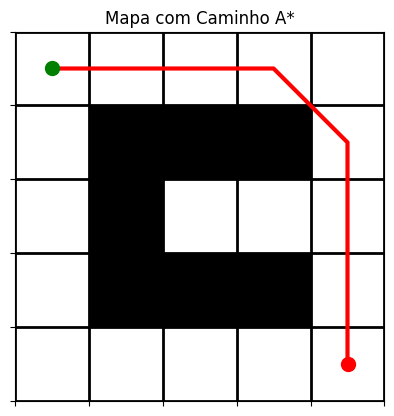

In [135]:
mapa = [
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
]

inicio = (0, 0)
fim = (4, 4)

problema_navegacao = problema_navegacao(mapa, inicio, fim)
exibir_labirinto_com_caminho(problema_navegacao)


Estado atual: [(0, (2, 0))]
Estado atual: [(5.123105625617661, (1, 0)), (5.123105625617661, (3, 0))]
Estado atual: [(5.123105625617661, (3, 0)), (6.47213595499958, (0, 0)), (6.019764837837084, (0, 1))]
Estado atual: [(6.019764837837084, (0, 1)), (6.019764837837084, (4, 1)), (6.47213595499958, (4, 0)), (6.47213595499958, (0, 0))]
Estado atual: [(6.019764837837084, (4, 1)), (6.242640687119286, (0, 2)), (6.47213595499958, (4, 0)), (6.47213595499958, (0, 0))]
Estado atual: [(6.242640687119286, (0, 2)), (6.242640687119286, (4, 2)), (6.47213595499958, (4, 0)), (6.47213595499958, (0, 0))]
Estado atual: [(6.242640687119286, (4, 2)), (6.47213595499958, (0, 0)), (6.47213595499958, (4, 0)), (6.650281539872885, (0, 3))]
Estado atual: [(6.47213595499958, (0, 0)), (6.650281539872885, (0, 3)), (6.47213595499958, (4, 0)), (6.650281539872885, (4, 3))]
Estado atual: [(6.47213595499958, (4, 0)), (6.650281539872885, (0, 3)), (6.650281539872885, (4, 3))]
Estado atual: [(6.650281539872885, (0, 3)), (6.65028

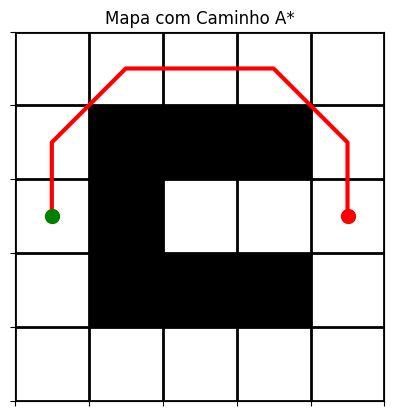

In [142]:
mapa_2 = [
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
]

inicio2 = (2, 0)
fim2 = (2, 4)

navegacao2 = problema_navegacao(mapa_2, inicio2, fim2)
exibir_labirinto_com_caminho(navegacao2)


Estado atual: [(0, (0, 0))]
Estado atual: [(7.4031242374328485, (0, 1)), (7.4031242374328485, (1, 0))]
Estado atual: [(7.4031242374328485, (1, 0)), (7.830951894845301, (0, 2))]
Estado atual: [(7.414213562373095, (2, 1)), (7.830951894845301, (2, 0)), (7.830951894845301, (0, 2))]
Estado atual: [(7.65685424949238, (2, 2)), (7.830951894845301, (2, 0)), (7.830951894845301, (0, 2)), (9.213591931880693, (3, 0))]
Estado atual: [(7.65685424949238, (3, 3)), (7.830951894845301, (0, 2)), (9.213591931880693, (3, 0)), (8.019764837837084, (2, 3)), (7.830951894845301, (2, 0))]
Estado atual: [(7.830951894845301, (0, 2)), (7.830951894845301, (2, 0)), (9.213591931880693, (3, 0)), (8.019764837837084, (2, 3)), (8.06449510224598, (4, 3)), (9.404918347287664, (4, 2))]
Estado atual: [(7.830951894845301, (2, 0)), (8.019764837837084, (2, 3)), (8.385164807134505, (0, 3)), (9.404918347287664, (4, 2)), (8.06449510224598, (4, 3)), (9.213591931880693, (3, 0))]
Estado atual: [(8.019764837837084, (2, 3)), (8.064495102

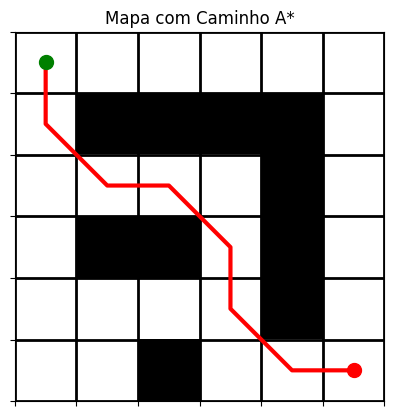

In [141]:
mapa3 = [
    [0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 0]
]

inicio3 = (0, 0)
fim3 = (5, 5)

# Execução

novo_problema_navegacao = problema_navegacao(mapa3, inicio3, fim3)
exibir_labirinto_com_caminho(novo_problema_navegacao)